In [47]:
import gurobipy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# PROBLEM 1

In [48]:
# demand of each itinerary
demand = [[25, 20], 
          [55, 40],
          [65, 25],
          [24, 16],
          [65, 50],
          [40, 35],
          [21, 20], 
          [25, 14]]
# cost of each itinerary
fares = [[200, 230], 
         [320, 420],
         [400, 490],
         [250, 290],
         [410, 550],
         [450, 550],
         [200, 230], 
         [250, 300]]
# number of seats occupied by each itinerary
seats = [[1, 0, 0, 0], 
         [1, 0, 1, 0],
         [1, 0, 0, 1],
         [0, 1, 0, 0],
         [0, 1, 1, 0],
         [0, 1, 0, 1],
         [0, 0, 1, 0], 
         [0, 0, 0, 1]]
N = len(demand) # number of itineraries
F = len(seats[0]) # number of flights

In [49]:
# create a new model
m = gp.Model("Network Revenue Management")

# create variables = number of tickets sold on each itinerary (Q and Y classes) 
q = m.addVars(N, vtype=gp.GRB.CONTINUOUS, lb = 0, name="Q")
y = m.addVars(N, vtype=gp.GRB.CONTINUOUS, lb = 0, name="Y")

# objective function
objExpr = gp.LinExpr()
for i in range(N):
    objExpr += fares[i][0]*q[i] + fares[i][1]*y[i]
m.setObjective(objExpr, gp.GRB.MAXIMIZE)

In [50]:
# tickets sold are lower than the demand
for i in range(N):
    m.addConstr(lhs = q[i], sense = gp.GRB.LESS_EQUAL, rhs = demand[i][0], name = "demand q class " + str(i))
    m.addConstr(lhs = y[i], sense = gp.GRB.LESS_EQUAL, rhs = demand[i][1], name = "demand y class " + str(i))

# number of seats occupied by each itinerary
for j in range(F):
    constrExpr = gp.LinExpr()
    for i in range(N):
        constrExpr += seats[i][j]*q[i] + seats[i][j]*y[i]
    m.addConstr(lhs = constrExpr, sense = gp.GRB.LESS_EQUAL, rhs = 200, name = "seats occupied " + str(j))


In [51]:
m.write(filename = "HW2_PARM_ft232.lp")

# optimize the model
m.optimize()

# print optimal objective and optimal solution
print("\nOptimal Objective: " + str(m.ObjVal))
print("\nOptimal Solution:")
allVars = m.getVars()
for var in allVars:
    print(var.varName + " " + str(var.x))

# print dual variables
print("\nDual Variables:")
duals = m.getAttr("Pi", m.getConstrs())
print(duals)

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 20 rows, 16 columns and 40 nonzeros
Model fingerprint: 0x41a2674b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 16 rows and 0 columns
Presolve time: 0.01s
Presolved: 4 rows, 16 columns, 24 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2725000e+05   5.062500e+01   0.000000e+00      0s
       6    1.8228000e+05   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds
Optimal objective  1.822800000e+05

Optimal Objective: 182280.0

Optimal Solution:
Q[0] 25.0
Q[1] 25.0
Q[2] 65.0
Q[3] 19.0
Q[4] 44.0
Q[5] 36.0
Q[6] 21.0
Q[7] 25.0
Y[0] 20.0
Y[1] 40.0
Y[2] 25.0
Y[3] 16.0
Y[4] 50.0
Y[5] 35.0
Y[6] 20.0
Y[7] 14.0

Dual Variables:
[40.0, 70.0, 0.0, 100.0, 40.0, 130.0, 0.0, 40.0, 0.0, 140.0, 0.0, 100.0, 40.0, 70.0, 50.0, 100.0, 16

# PROBLEM 2

In [52]:
df2 = pd.read_excel("Demand.xlsx", sheet_name='Sheet1')
x = df2['price'].values.reshape(-1, 1)
y = df2['Demand'].values.reshape(-1, 1)
m = LinearRegression().fit(x, y)
a = m.intercept_[0]
b = m.coef_[0][0]
print('the line is: ' +  str(a) + str(b) + 'x')

the line is: 395.3217512993542-1.9797083268982867x


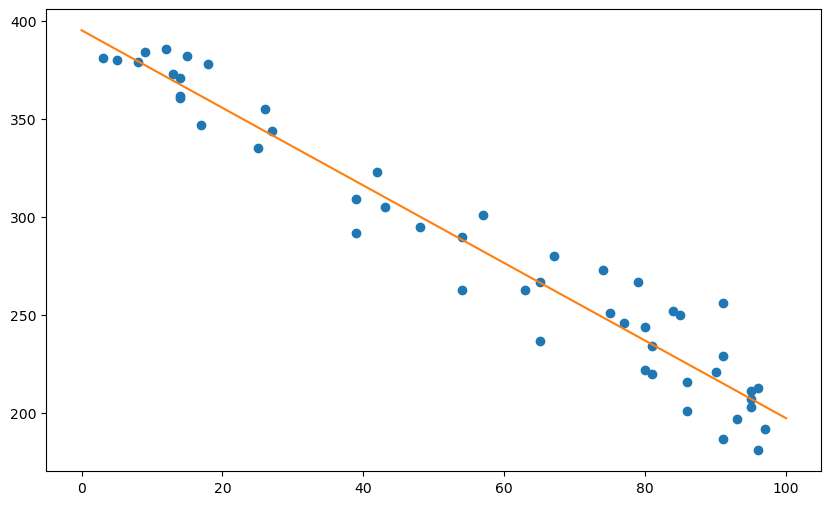

In [53]:
# plot the demand curve
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o')
x1 = np.linspace(0, 100, 10)
y1 = a + b * x1
plt.plot(x1, y1, '-')
plt.savefig('demand.png')
plt.show()

In [54]:
print('The optimal value is ' + str(-a/(2*b)))

The optimal value is 99.84343297649448


# Problem 3

In [55]:
df3 = pd.read_excel("InSample.xlsx", sheet_name='Sheet1')

In [56]:
def wtp(df, p):
    no_buy = 0
    buy = 0
    for i in range(len(df)):
        if df['p_i'][i] >= p and df['y_i'][i] == 1:
            buy += 1
        elif df['p_i'][i] <= p and df['y_i'][i] == 0:
            no_buy += 1
    return buy / (no_buy + buy)

In [57]:
xw = []
Fw = []
for i in range(max(df3['p_i'] + 1)):
    xw.append(i)
    Fw.append(1 - wtp(df3, i))

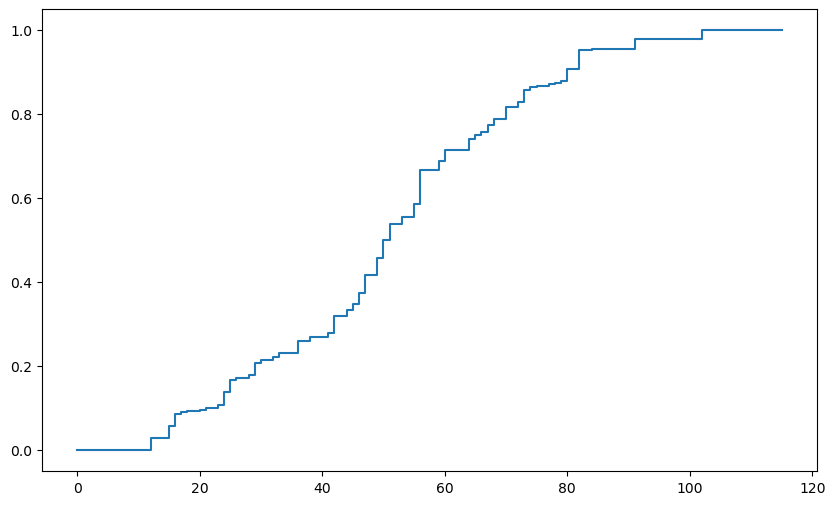

In [58]:
# plot the willingness to pay curve
plt.figure(figsize=(10, 6))
plt.step(xw, Fw, where = 'post')
plt.savefig('willingness_to_pay_F.png')
plt.show()

In [59]:
def expected_revenue(df, p):
    revenue = 0
    count = 0
    for i in range(len(df)):
        if df['p_i'][i] >= p and df['y_i'][i] == 1:
            revenue += p
            count += 1
    return revenue/len(df)

The optimal price is 40


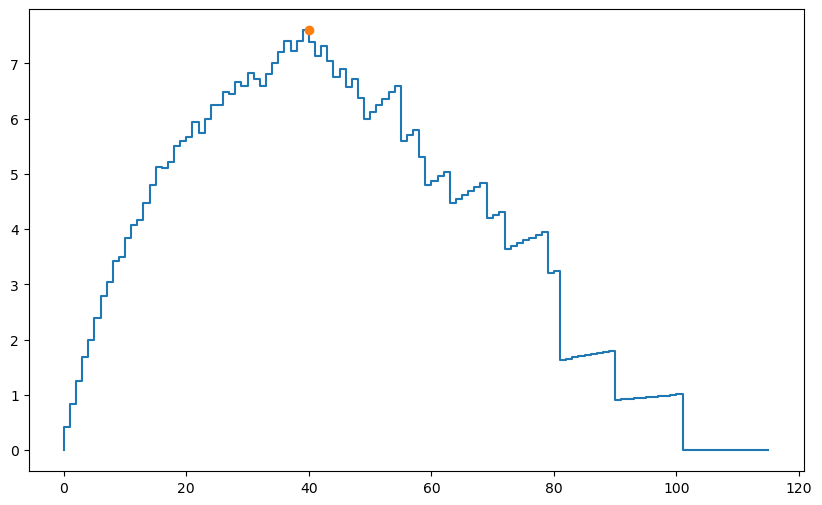

In [60]:
revenues = [expected_revenue(df3, p) for p in range(max(df3['p_i'] + 1))]
pstar = xw[np.argmax(revenues)]
print('The optimal price is ' + str(pstar))
plt.figure(figsize=(10, 6))
plt.step(xw, revenues, '-')
plt.plot(pstar, max(revenues), 'o')
plt.savefig('revenue.png')
plt.show()

In [61]:
def compute_revenue(W, p):
    revenue = 0
    for i in range(len(W)):
        if W[i] >= p:
            revenue += p
    return revenue

In [62]:
df3b = pd.read_excel("OutOfSample.xlsx", sheet_name='Sheet1')
wtp_vector = list(df3b['WTP'])
print('The revenue for the optimal price is ' + str(compute_revenue(wtp_vector, pstar)))

The revenue for the optimal price is 1000
